In [1]:
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import osmnx as ox
import networkx as nx

import sys, os

%matplotlib inline

In [2]:
PROJECT_PATH = "/Users/frankkelly/Dropbox/Projects-new/bristol_emissions/"
config_path = os.path.join(PROJECT_PATH, "src", "conf")

In [3]:
loop_df = pd.read_csv(os.path.join(PROJECT_PATH, "data", "raw", "guildford_loop_1 - guildford_loop_1.csv.csv"))

In [4]:
loop_df.head()

Time Stamp [s]    NO [ppm]  Calculated engine load [%]  \
0         445.300  137.356792                         0.0   
1         445.310  138.305559                         0.0   
2         445.320  138.146337                         0.0   
3         445.335  139.587544                         0.0   
4         445.340  139.587544                         0.0   

   Intake manifold absolute pressure [kPa]  Engine Speed [RPM]  \
0                                    113.0             2002.75   
1                                    113.0             2002.75   
2                                    113.0             2002.75   
3                                    108.0             2002.75   
4                                    108.0             2002.75   

   Vehicle speed [km/h]  MAF air flow rate [g/s]  GPS Time stamp   Latitude  \
0                  49.0                    40.59         39301.6  51.239646   
1                  49.0                    40.59         39301.6  51.239646   
2                  49.0                    40.59         39301.6  51.239646   
3                  49.0                    40.59         39301.6  51.239646   
4                  49.0                    40.59         39301.6  51.239646   

   Longitude  GPS-Quality  Satellites  HDop  Altitude [m]  GPS Speed [km/h]  \
0  -0.575852          5.0        13.0     1        41.337           50.0966   
1  -0.575852          5.0        13.0     1        41.295           50.0966   
2  -0.575852          5.0        13.0     1        41.295           50.0966   
3  -0.575852          5.0        13.0     1        41.295           50.0966   
4  -0.575852          5.0        13.0     1        41.295           50.0966   

   Comments  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

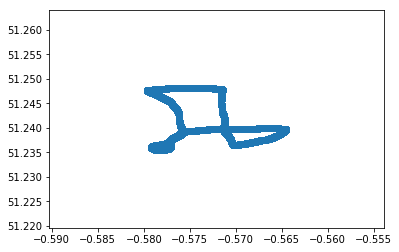

In [5]:
plt.scatter(loop_df.Longitude, loop_df.Latitude)
plt.show()

Let's check to see if the same roads have been driven over several times

How about we animate this graph?

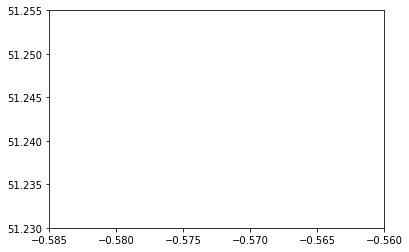

In [6]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -0.585, -0.560))
ax.set_ylim((51.230, 51.255))

line, = ax.plot([], [], lw=2)

In [7]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [8]:
loop_df[:5].Longitude

0   -0.575852
1   -0.575852
2   -0.575852
3   -0.575852
4   -0.575852
Name: Longitude, dtype: float64

In [9]:
loop_df_sampled = loop_df.sample(1000).sort_values(by="Time Stamp [s]")

In [10]:
# animation function. This is called sequentially
def animate(i):
    x, y = loop_df_sampled[:i].Longitude, loop_df_sampled[:i].Latitude
#     x = np.linspace(0, 2, 1000)
#     y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

In [11]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, 
                               animate, 
                               init_func=init,
                               frames=1000,
                               interval=20,
                               blit=True
                              )


In [12]:
HTML(anim.to_html5_video())


We now have an animated trace of the route around Guildford

In [13]:

loop_df_sampled[["NO [ppm]", "Vehicle speed [km/h]"]].plot()
plt.show()

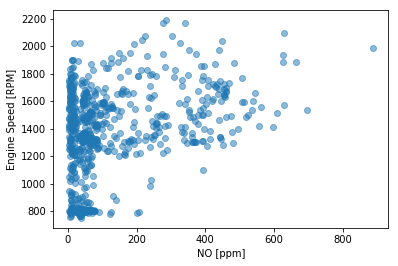

In [14]:
chosen_x = "NO [ppm]"
chosen_y = "Engine Speed [RPM]"

plt.scatter(loop_df_sampled[chosen_x], loop_df_sampled[chosen_y], alpha=0.5)
plt.xlabel(chosen_x)
plt.ylabel(chosen_y)

plt.show()


Let's get a map of Guildford loaded into a networkx graph

In [15]:
place = 'Guildford, United Kingdom'

In [16]:
# G = ox.graph_from_place(place, 
#                         network_type='drive',
#                          retain_all=False, # Only keep biggest connected network
#                        infrastructure='way["highway"]',# Look for osm highway features
# #                         custom_filter='["highway"~"motorway|trunk|primary|secondary|tertiary"]', # Add highway type filters here
#                        truncate_by_edge=True # Keep entirety of edges, rather than cropping at distance limit
#                        )

In [17]:
guildford =  ox.graph_from_point((loop_df['Latitude'].median(),loop_df['Longitude'].median()), distance=1000,
                         network_type='drive',
                        retain_all=False, # Only keep biggest connected network
                        distance_type='bbox', # Determine distance using crow-flies, not network
                        truncate_by_edge=True, # Keep entirety of edges, rather than cropping at distance limit
                        infrastructure='way["highway"]', # Look for osm highway features
#                         custom_filter='["highway"~"motorway|trunk|primary|secondary|tertiary"]', # Add highway type filters here
                        ) 

plot graph using OSMNx

And let's add road test observation points to the graph 

In [18]:
import folium

mapa = ox.plot_graph_folium(guildford)
for index, row in loop_df_sampled.sample(150).iterrows():
    folium.Marker(location=(row['Latitude'],row['Longitude'])).add_to(mapa)
# folium.Marker(location=(loop_df['Latitude'].min(),loop_df['Longitude'].min())).add_to(mapa)
mapa

Is Guildford hilly? Let's plot the gradient onto the map

In [19]:
import configparser

In [20]:
config = configparser.ConfigParser()
config.read(os.path.join(config_path,'config.ini'))

['/Users/frankkelly/Dropbox/Projects-new/bristol_emissions/src/conf/config.ini']

In [21]:
google_elevation_api_key = config['API_KEYS']['googlemaps']

In [22]:

# add elevation to each of the nodes, using the google elevation API, then calculate edge grades
guildford = ox.add_node_elevations(guildford, api_key=google_elevation_api_key)
guildford = ox.add_edge_grades(guildford)

Let's store this graph for future reference

In [23]:
graph_dir = os.path.join(PROJECT_PATH, "graphs")
# Save graph
nx.write_gpickle(guildford, os.path.join(graph_dir, "graph_guildford_with_elevation.gpkl"))

# Calculate some summary stats
Use an undirected representation of the network so we don't overcount two-way streets (because they have reciprocal edges pointing in each direction). We use the absolute value of edge grade because we're interested in steepness, not directionality.

In [24]:

edge_grades = [data['grade_abs'] for u, v, k, data in ox.get_undirected(guildford).edges(keys=True, data=True)]

In [25]:

avg_grade = np.mean(edge_grades)
print('Average street grade in {} is {:.1f}%'.format(place, avg_grade*100))

med_grade = np.median(edge_grades)
print('Median street grade in {} is {:.1f}%'.format(place, med_grade*100))

Average street grade in Guildford, United Kingdom is 3.0%
Median street grade in Guildford, United Kingdom is 2.0%


Let's plot the nodes by elevation; colored from low (violet) to high (yellow).

In [26]:

# project the street network to UTM
guildford_projected = ox.project_graph(guildford)

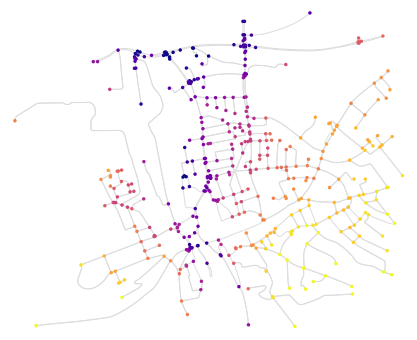

In [27]:

# get one color for each node, by elevation, then plot the network
nc = ox.get_node_colors_by_attr(guildford_projected, 'elevation', cmap='plasma', num_bins=20)
fig, ax = ox.plot_graph(guildford_projected, fig_height=6, node_color=nc, node_size=12, node_zorder=2, edge_color='#dddddd')


## Plot the edges by grade
Grade is the ratio of elevation change to edge length. Plot edges colored from low/flat (violet) to high/steep (yellow).

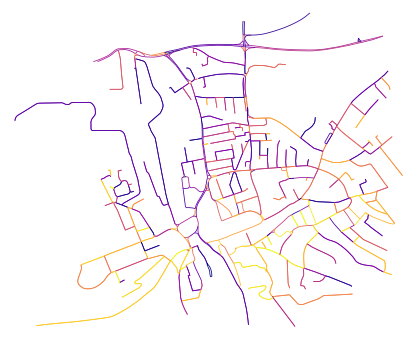

In [28]:
# get a color for each edge, by grade, then plot the network
ec = ox.get_edge_colors_by_attr(guildford_projected, 'grade_abs', cmap='plasma', num_bins=100)
fig, ax = ox.plot_graph(guildford_projected, fig_height=6, edge_color=ec, edge_linewidth=0.8, node_size=0)

In [29]:
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [30]:
geometry_lat_long = [Point(xy) for xy in zip(loop_df_sampled.Longitude, loop_df_sampled.Latitude)]

crs_latlong = {'init': 'epsg:4326'}

loop_gdf = GeoDataFrame(loop_df_sampled, crs=crs_latlong, geometry=geometry_lat_long)

loop_gdf.head()

Time Stamp [s]    NO [ppm]  Calculated engine load [%]  \
54        445.82000  103.615932                   68.627451   
252       447.80595  215.073614                   15.686275   
358       448.87000   34.409048                    0.000000   
491       450.18000   16.436655                    0.000000   
511       450.40000   16.594236                    0.784314   

     Intake manifold absolute pressure [kPa]  Engine Speed [RPM]  \
54                                      96.0             1451.25   
252                                     83.0             1492.50   
358                                     75.0             1466.75   
491                                     74.0             1419.25   
511                                     74.0             1418.25   

     Vehicle speed [km/h]  MAF air flow rate [g/s]  GPS Time stamp   Latitude  \
54                   49.0                    28.00         39302.0  51.239699   
252                  51.0                    19.25         39304.0  51.239952   
358                  50.0                    25.78         39305.0  51.240086   
491                  48.0                    24.65         39306.4  51.240249   
511                  48.0                    24.87         39306.6  51.240272   

     Longitude  GPS-Quality  Satellites  HDop  Altitude [m]  GPS Speed [km/h]  \
54   -0.575859          5.0        13.0     1       41.2530          49.74472   
252  -0.575910          4.0        12.0     1       40.7555          51.93008   
358  -0.575939          4.0        13.0     1       40.6640          50.46700   
491  -0.575974          4.0        14.0     1       40.5700          48.94836   
511  -0.575979          4.0        14.0     1       40.5650          48.91132   

     Comments                                 geometry  
54        NaN  POINT (-0.5758594136999999 51.23969861)  
252       NaN    POINT (-0.5759099732999999 51.239952)  
358       NaN         POINT (-0.575938759 51.24008558)  
491       NaN         POINT (-0.5759741168 51.2402488)  
511       NaN        POINT (-0.5759790698 51.24027222)

In [31]:
loop_gdf['Longitude'].isna().sum()

0

In [32]:
# Drop the locations without location values
print(loop_gdf.shape)
loop_clean_gdf = loop_gdf[(~loop_gdf['Longitude'].isnull()) 
                             & ~loop_gdf['Latitude'].isnull()].copy()
print(loop_clean_gdf.shape)

(1000, 17)
(1000, 17)


In [33]:
gjson = loop_gdf.to_crs(epsg='4326').to_json()


Plot all observation points onto the map to see where we have decent coverage

In [34]:
def plot_gdf_folium(df, gjson, zoom=6):
    """
    Plot a folium map of a dataframe
    Parameters
    ----------
    gdf: pandas dataframe
        Must have columns 'lat' and 'long' containing latitude and longitude respectively
    zoom: int
        zoom_start of the folium map
    Returns
    -------
    folium map
        Map of row locations
    """
    df = df.sample(100).copy()
    centre_lat = (df['Latitude'].max()+df['Latitude'].min())/2
    centre_lng = (df['Longitude'].max()+df['Longitude'].min())/2

    mapa = folium.Map(width=400,height=500,location=[centre_lat, centre_lng], 
                      zoom_start = zoom)
    
    points = folium.features.GeoJson(gjson)
    mapa.add_children(points)

#     for _,row in df.iterrows():
#             folium.CircleMarker(location=(row['lat'], row['long']), fill=True,
#                                 radius=2).add_to(mapa)

    return mapa

# plot_df_folium(waterlevelDF)
plot_gdf_folium(loop_gdf, gjson, 14)

/Users/frankkelly/.virtualenvs/bristol-emissions-env/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


Let's go through the sampled_df and find the points closest to each graph node

In [35]:
nodes = []
for index, row in loop_df_sampled.iterrows():
    nearest_node = ox.get_nearest_node(guildford, (row['Latitude'], 
                                                   row['Longitude']))
    nodes.append(nearest_node)
loop_df_sampled['Node'] = nodes

In [36]:
loop_df_sampled.head()

Time Stamp [s]    NO [ppm]  Calculated engine load [%]  \
54        445.82000  103.615932                   68.627451   
252       447.80595  215.073614                   15.686275   
358       448.87000   34.409048                    0.000000   
491       450.18000   16.436655                    0.000000   
511       450.40000   16.594236                    0.784314   

     Intake manifold absolute pressure [kPa]  Engine Speed [RPM]  \
54                                      96.0             1451.25   
252                                     83.0             1492.50   
358                                     75.0             1466.75   
491                                     74.0             1419.25   
511                                     74.0             1418.25   

     Vehicle speed [km/h]  MAF air flow rate [g/s]  GPS Time stamp   Latitude  \
54                   49.0                    28.00         39302.0  51.239699   
252                  51.0                    19.25         39304.0  51.239952   
358                  50.0                    25.78         39305.0  51.240086   
491                  48.0                    24.65         39306.4  51.240249   
511                  48.0                    24.87         39306.6  51.240272   

     Longitude  GPS-Quality  Satellites  HDop  Altitude [m]  GPS Speed [km/h]  \
54   -0.575859          5.0        13.0     1       41.2530          49.74472   
252  -0.575910          4.0        12.0     1       40.7555          51.93008   
358  -0.575939          4.0        13.0     1       40.6640          50.46700   
491  -0.575974          4.0        14.0     1       40.5700          48.94836   
511  -0.575979          4.0        14.0     1       40.5650          48.91132   

     Comments                                 geometry      Node  
54        NaN  POINT (-0.5758594136999999 51.23969861)  30022986  
252       NaN    POINT (-0.5759099732999999 51.239952)  30022986  
358       NaN         POINT (-0.575938759 51.24008558)  30023002  
491       NaN         POINT (-0.5759741168 51.2402488)  30023002  
511       NaN        POINT (-0.5759790698 51.24027222)  30023002

That's the closest node in each case, however doesn't really give us which road the data is from. 
Furthermore, as OSMNx doesn't have a "closest edge" function, we have to write our own using this data type: 
shapely.geometry.LineString

In [66]:
G.edges(data=True)

OutMultiEdgeDataView([(19874816, 26201475, {'osmid': 4397766, 'oneway': True, 'lanes': '2', 'ref': 'A322', 'name': 'Onslow Street', 'highway': 'primary', 'maxspeed': '30 mph', 'length': 61.56, 'geometry': <shapely.geometry.linestring.LineString object at 0x120fd0048>, 'grade': -0.0411, 'grade_abs': 0.0411}), (19874816, 19874813, {'osmid': 154571469, 'oneway': True, 'ref': 'A322', 'name': 'Onslow Street', 'highway': 'primary', 'maxspeed': '30 mph', 'length': 28.476, 'geometry': <shapely.geometry.linestring.LineString object at 0x120fd0080>, 'grade': -0.0068, 'grade_abs': 0.0068}), (6193464321, 20628585, {'osmid': 4413881, 'name': 'High Street', 'highway': 'unclassified', 'maxspeed': '30 mph', 'oneway': False, 'length': 3.946, 'grade': 0.0096, 'grade_abs': 0.0096}), (251318276, 10615545, {'osmid': 2429801, 'ref': 'A246', 'name': 'Epsom Road', 'highway': 'primary', 'maxspeed': '30 mph', 'oneway': False, 'length': 9.153, 'grade': -0.0191, 'grade_abs': 0.0191}), (251318276, 251318282, {'osm